In [1]:
import sys, os
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.insert(0, project_root)


In [2]:
import pandas as pd
from src.load_data import load_data
import src.eda
import importlib
importlib.reload(src.eda)
from src.eda import summarize, missing_check, get_variable_types, plot_correlations, plot_distributions, plot_boxplots, skew_check, calculate_vif, drop_outliers_iqr, one_hot_encode
import numpy as np

In [3]:
# load data
df = load_data("data/airbnb_df.csv")

print(summarize(df))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3982 entries, 0 to 3981
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   listing_id           3982 non-null   int64  
 1   property_type        3982 non-null   object 
 2   number_of_bedrooms   3982 non-null   int64  
 3   guest_capacity       3982 non-null   int64  
 4   location_score       3982 non-null   float64
 5   review_score         3982 non-null   float64
 6   amenities_count      3982 non-null   int64  
 7   host_response_time   3982 non-null   object 
 8   season               3982 non-null   object 
 9   minimum_stay_nights  3982 non-null   int64  
 10  years_as_host        3982 non-null   float64
 11  cleaning_fee         3982 non-null   float64
 12  cancellation_policy  3982 non-null   object 
 13  nightly_rate         3982 non-null   float64
dtypes: float64(5), int64(5), object(4)
memory usage: 435.7+ KB
None
          listing_id  nu

In [4]:
df.head()

,listing_id,property_type,number_of_bedrooms,guest_capacity,location_score,review_score,amenities_count,host_response_time,season,minimum_stay_nights,years_as_host,cleaning_fee,cancellation_policy,nightly_rate
0,100822,Standard Apartment,2,4,75.17,4.87,8,within an hour,peak,2,1.6,21.43,flexible,187.29
1,100908,Standard Apartment,2,3,67.07,4.06,6,>24 hours,off-peak,2,4.1,38.30,flexible,255.64
2,101850,Standard Apartment,1,2,76.57,4.16,10,same day,off-peak,1,2.3,50.34,flexible,62.82
3,102385,Standard Apartment,2,2,88.14,3.74,11,same day,shoulder,2,1.6,35.37,strict,203.80
4,103827,Luxury Home,4,4,58.63,3.37,15,same day,peak,4,0.9,94.90,strict,1000.00


In [5]:
df = df.drop(columns=['listing_id'])

In [6]:
# check missing value
missing_check(df)

property_type          0
number_of_bedrooms     0
guest_capacity         0
location_score         0
review_score           0
amenities_count        0
host_response_time     0
season                 0
minimum_stay_nights    0
years_as_host          0
cleaning_fee           0
cancellation_policy    0
nightly_rate           0
dtype: int64

In [7]:
# classify variable types
num_cols, cat_cols = get_variable_types(df, "nightly_rate", 0) 
print(f'Numerical columns: {num_cols}')
print(f'Categorical columns: {cat_cols}')
target = df["nightly_rate"]

Numerical columns: ['number_of_bedrooms', 'guest_capacity', 'location_score', 'review_score', 'amenities_count', 'minimum_stay_nights', 'years_as_host', 'cleaning_fee']
Categorical columns: ['property_type', 'host_response_time', 'season', 'cancellation_policy']


### Numerical Columns

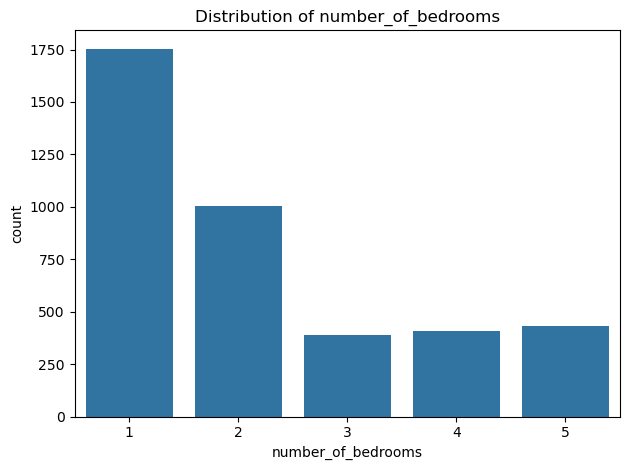

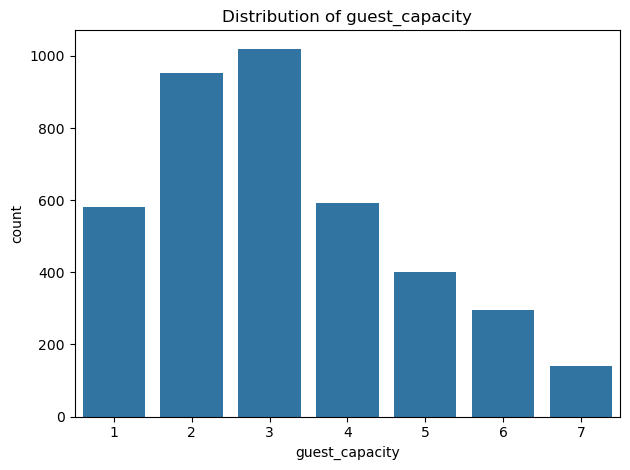

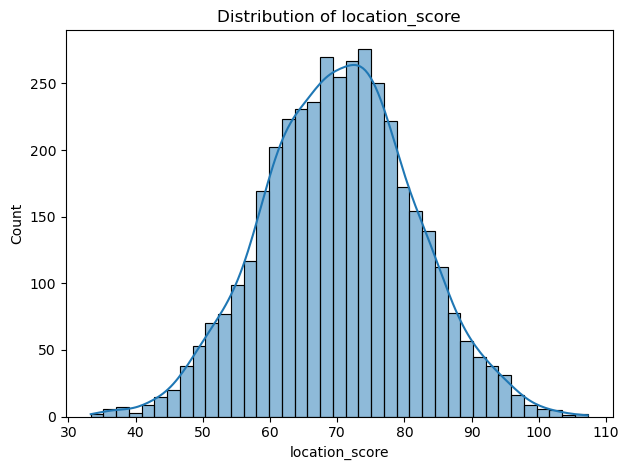

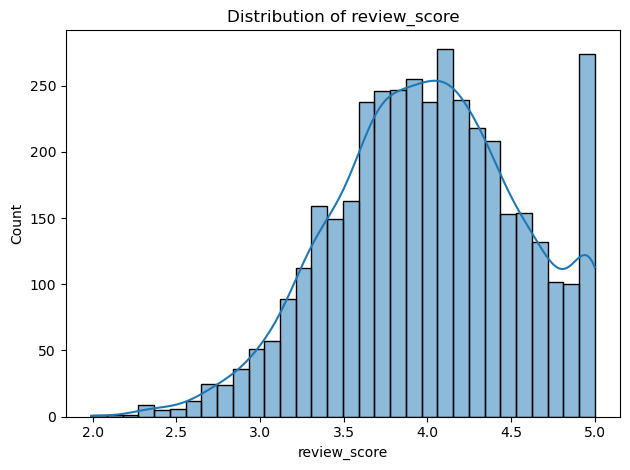

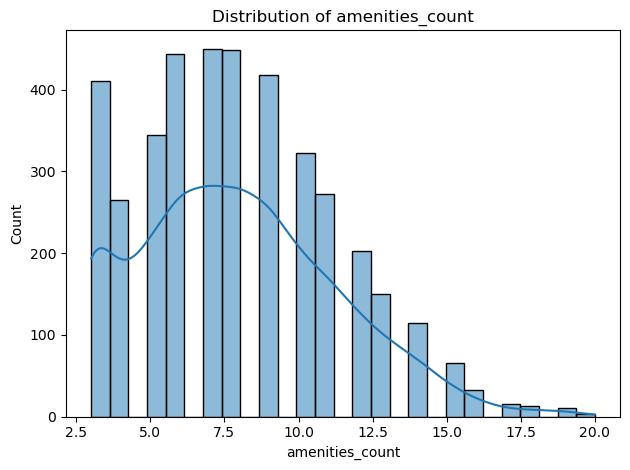

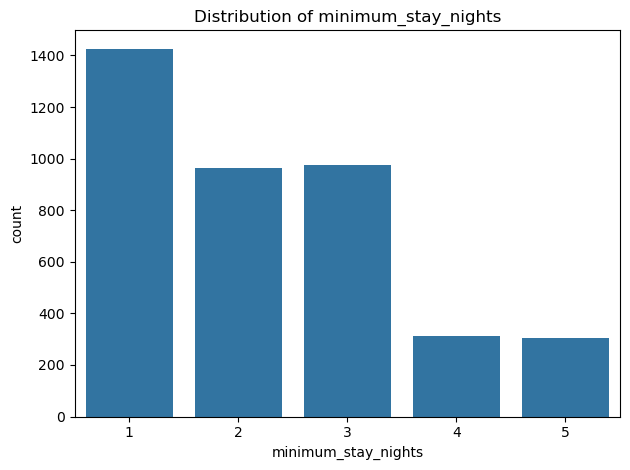

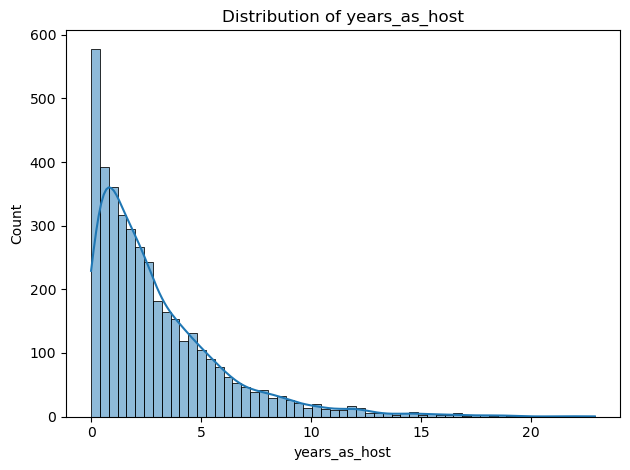

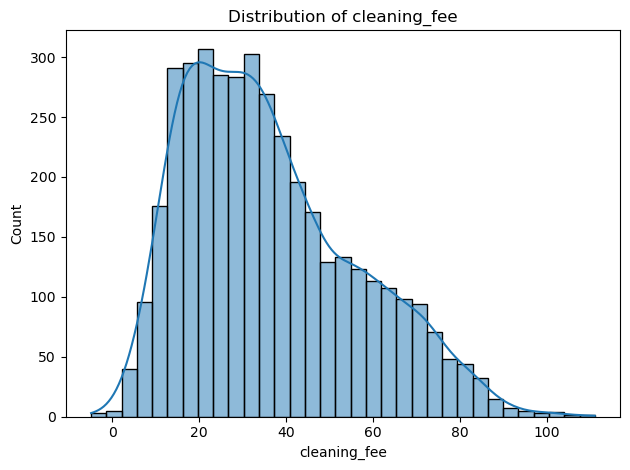

In [8]:
plot_distributions(df, num_cols)

In [9]:
# Check skewness
skew_check(df, num_cols)

number_of_bedrooms     0.903153
guest_capacity         0.581191
location_score        -0.020977
review_score          -0.165083
amenities_count        0.504965
minimum_stay_nights    0.688846
years_as_host          1.943478
cleaning_fee           0.680534
dtype: float64


**High skewness variable: (abs()>0.5)**
- number_of_bedrooms : mostly 1 or 2 bedrooms, could be ordinally encoded into 1, 2, 3+
- minimum_stay_nights : could be ordially encoded into 1, 2, 3, 4+
- years_as_host : Log transform
- cleaning_fee : Log transform



In [10]:
df_processed = df.copy()
# number_of_bedrooms

def bin_bedrooms(x):
    if x == 1:
        return "1"
    elif x == 2:
        return "2"
    else:
        return "3+" 
    
df_processed["bedroom_group"] = df_processed["number_of_bedrooms"].apply(bin_bedrooms)

# minimum_stay_nights

def bin_min_stay(x):
    if x == 1:
        return "1"
    elif x == 2:
        return "2"
    elif x == 3:
        return "3"
    else:
        return "4+"
    
df_processed["min_stay_group"] = df_processed["minimum_stay_nights"].apply(bin_min_stay)

# years_as_host, cleaning_fee

df_processed["years_as_host_log"] = np.log1p(df_processed["years_as_host"])
df_processed["cleaning_fee_log"] = np.log1p(df_processed["cleaning_fee"])



/opt/homebrew/Caskroom/miniconda/base/envs/ise535_project/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [11]:
num_cols_processed = list(set(num_cols) - {"number_of_bedrooms", "minimum_stay_nights", "years_as_host", "cleaning_fee"}) + ["bedroom_encoded", "min_stay_encoded", "years_as_host_log", "cleaning_fee_log"]

In [12]:
# add processed variable into df
df_processed["bedroom_encoded"] = df_processed["bedroom_group"].map({"1": 0, "2": 1, "3+": 2})
df_processed["min_stay_encoded"] = df_processed["min_stay_group"].map({"1": 0, "2": 1, "3": 2, "4+":3})

df_processed  = df_processed.drop(columns=['bedroom_group', 'min_stay_group'])

replace_cols = {
    "number_of_bedrooms": "bedroom_encoded",
    "minimum_stay_nights": "min_stay_encoded",
    "years_as_host": "years_as_host_log",
    "cleaning_fee": "cleaning_fee_log"
}

for old_col, new_col in replace_cols.items():
    df_processed[old_col] = df_processed[new_col] 

In [13]:
skew_check(df_processed, num_cols_processed)

guest_capacity       0.581191
location_score      -0.020977
amenities_count      0.504965
review_score        -0.165083
bedroom_encoded      0.256906
min_stay_encoded     0.326179
years_as_host_log    0.256794
cleaning_fee_log    -0.649864
dtype: float64

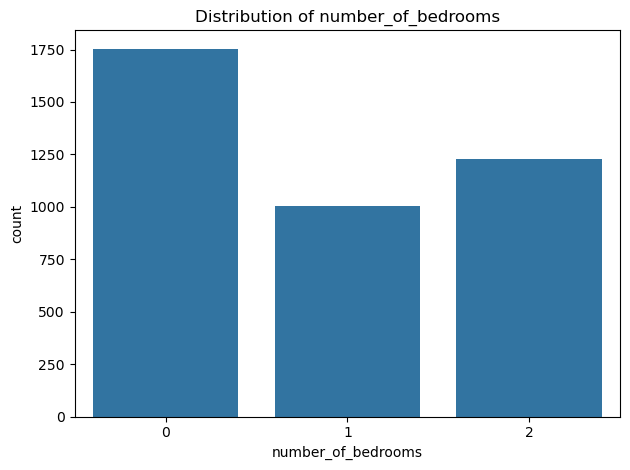

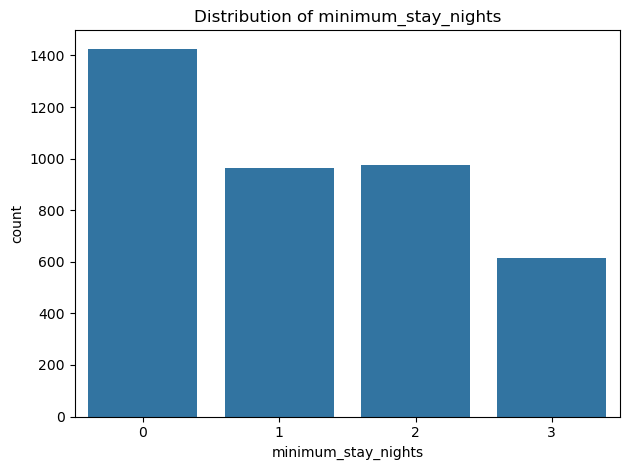

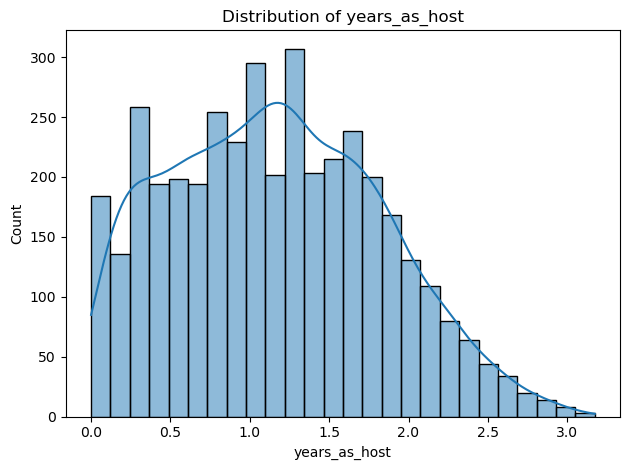

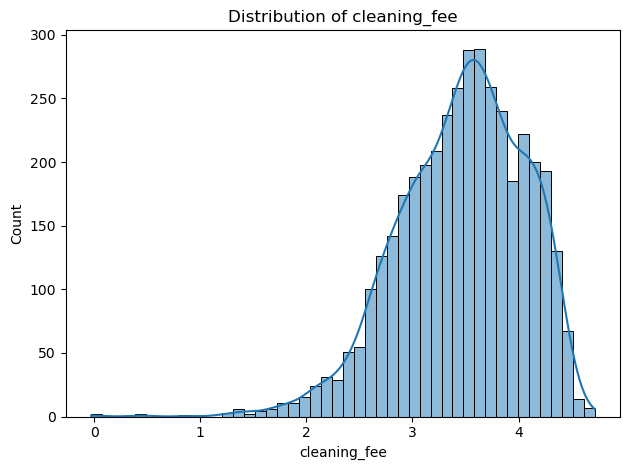

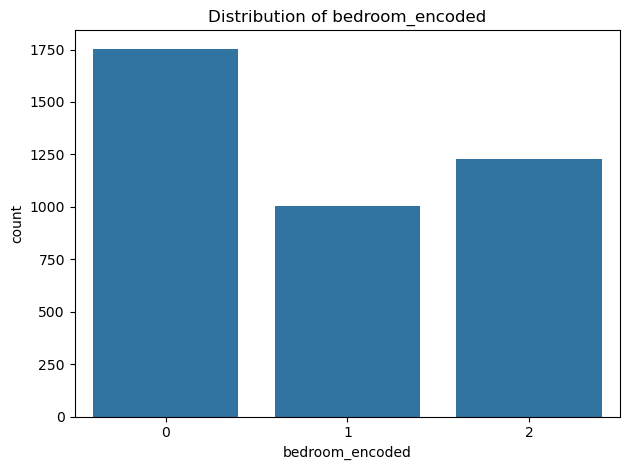

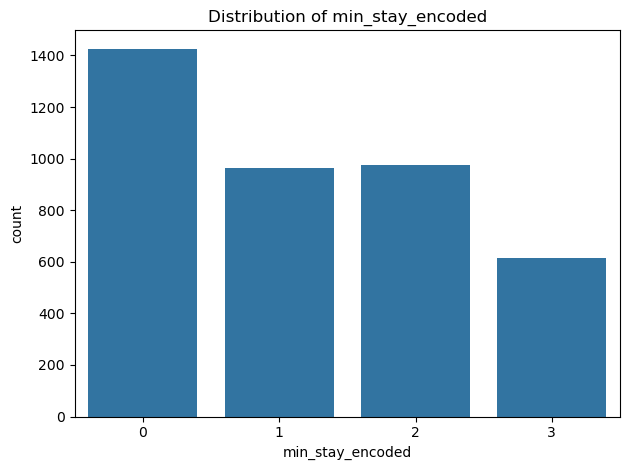

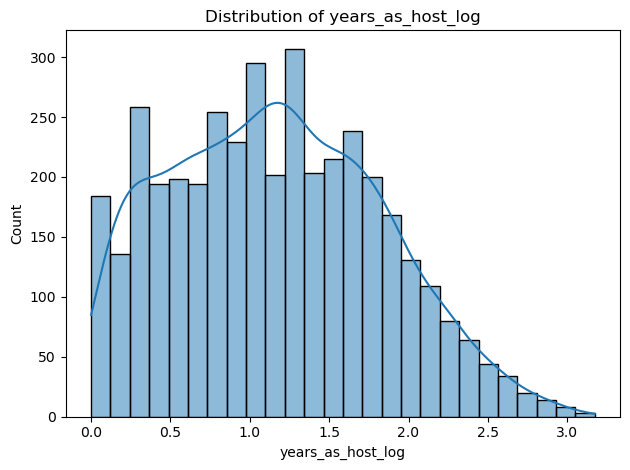

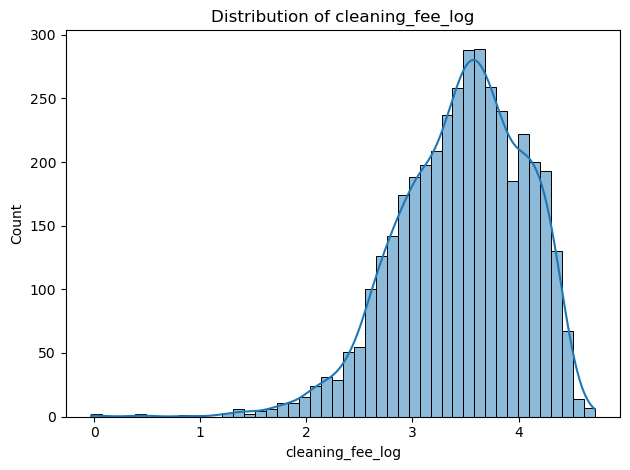

In [14]:
original_high_skew_cols = ["number_of_bedrooms", "minimum_stay_nights", "years_as_host", "cleaning_fee"]
processed_high_skew_cols = ["bedroom_encoded", "min_stay_encoded", "years_as_host_log", "cleaning_fee_log"]
plot_distributions(df_processed[original_high_skew_cols], original_high_skew_cols)
plot_distributions(df_processed[processed_high_skew_cols], processed_high_skew_cols)


In [15]:
# Outliers

df_outlier_processed = drop_outliers_iqr(df_processed, num_cols_processed)

Dropped 114 rows due to outliers in ['guest_capacity', 'location_score', 'amenities_count', 'review_score', 'bedroom_encoded', 'min_stay_encoded', 'years_as_host_log', 'cleaning_fee_log'].


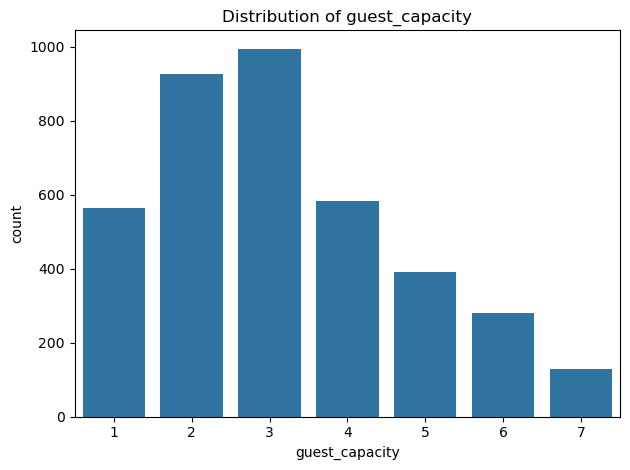

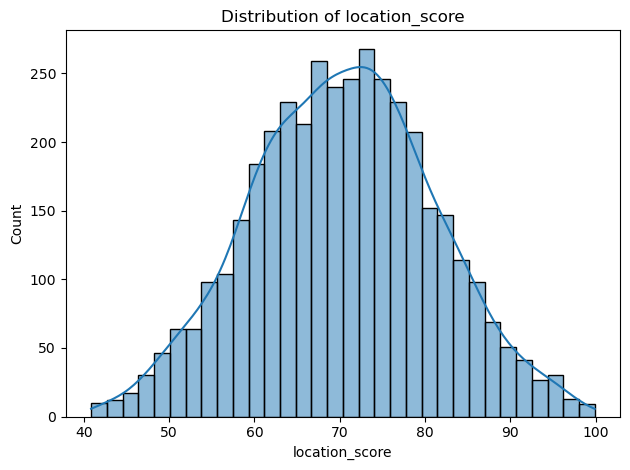

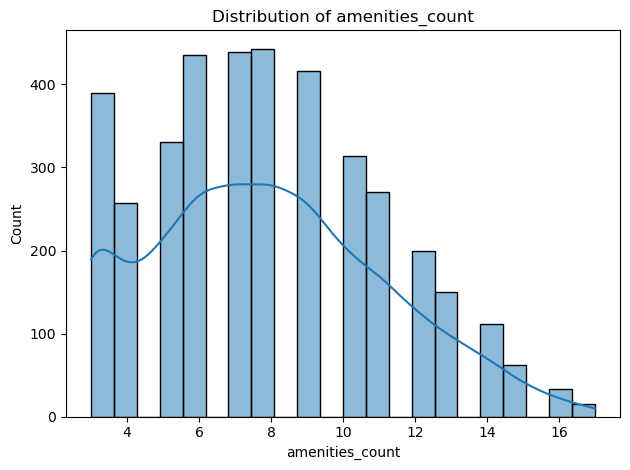

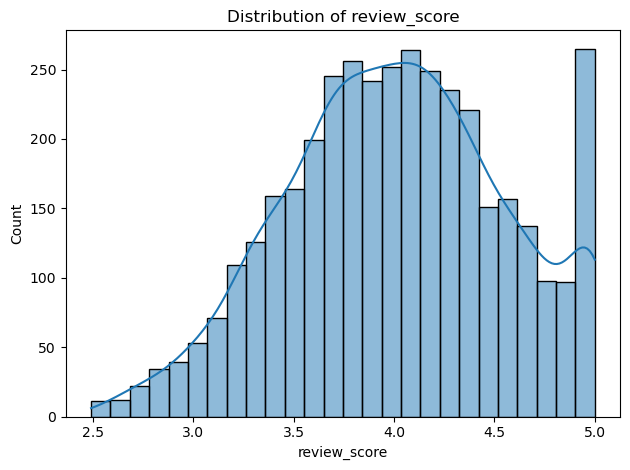

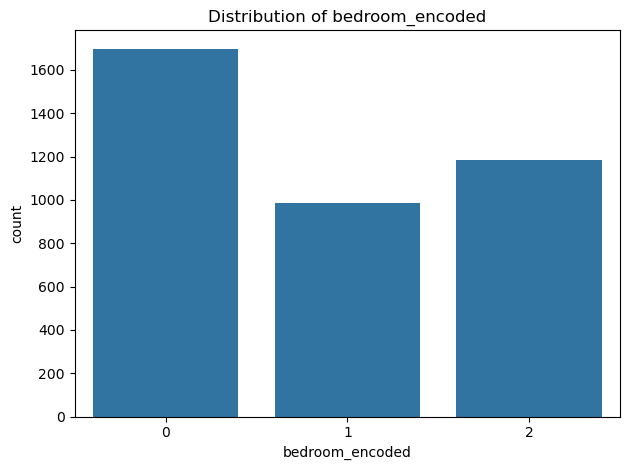

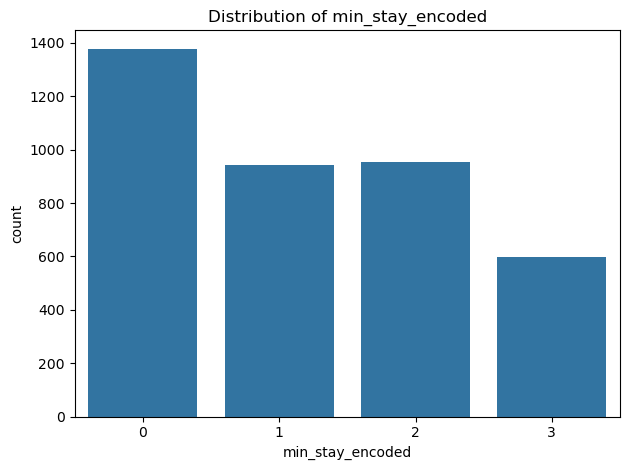

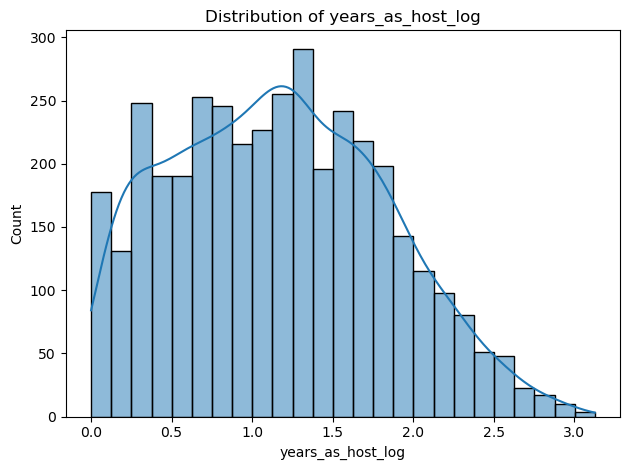

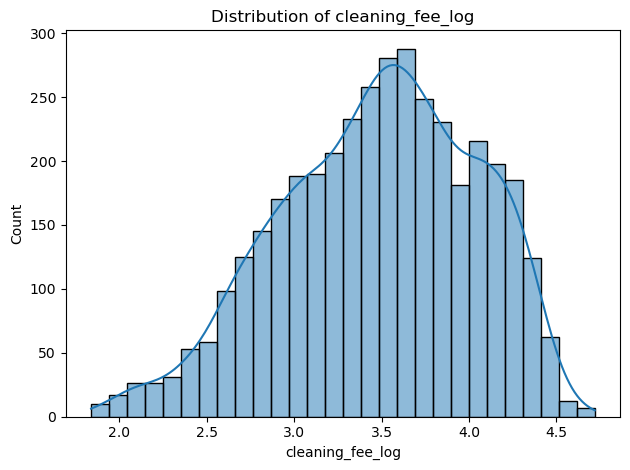

In [16]:
plot_distributions(df_outlier_processed, num_cols_processed)

In [17]:
# Check the 5.0 score on review_score
df_outlier_processed[df_outlier_processed["review_score"] == 5.0].describe()

,number_of_bedrooms,guest_capacity,location_score,review_score,amenities_count,minimum_stay_nights,years_as_host,cleaning_fee,nightly_rate,years_as_host_log,cleaning_fee_log,bedroom_encoded,min_stay_encoded
count,212.000000,212.000000,212.000000,212.0,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000
mean,0.919811,3.202830,80.815425,5.0,9.773585,1.268868,1.186338,3.495132,198.974245,1.186338,3.495132,0.919811,1.268868
std,0.875243,1.588284,8.822895,0.0,3.244486,1.096471,0.671596,0.559171,149.984129,0.671596,0.559171,0.875243,1.096471
min,0.000000,1.000000,56.510000,5.0,3.000000,0.000000,0.000000,2.096790,30.000000,0.000000,2.096790,0.000000,0.000000
25%,0.000000,2.000000,74.775000,5.0,7.000000,0.000000,0.641854,3.072576,96.697500,0.641854,3.072576,0.000000,0.000000
50%,1.000000,3.000000,81.350000,5.0,10.000000,1.000000,1.193922,3.512738,162.350000,1.193922,3.512738,1.000000,1.000000
75%,2.000000,4.000000,87.125000,5.0,12.000000,2.000000,1.672380,3.924149,246.935000,1.672380,3.924149,2.000000,2.000000
max,2.000000,7.000000,99.910000,5.0,17.000000,3.000000,2.727853,4.506565,1000.000000,2.727853,4.506565,2.000000,3.000000


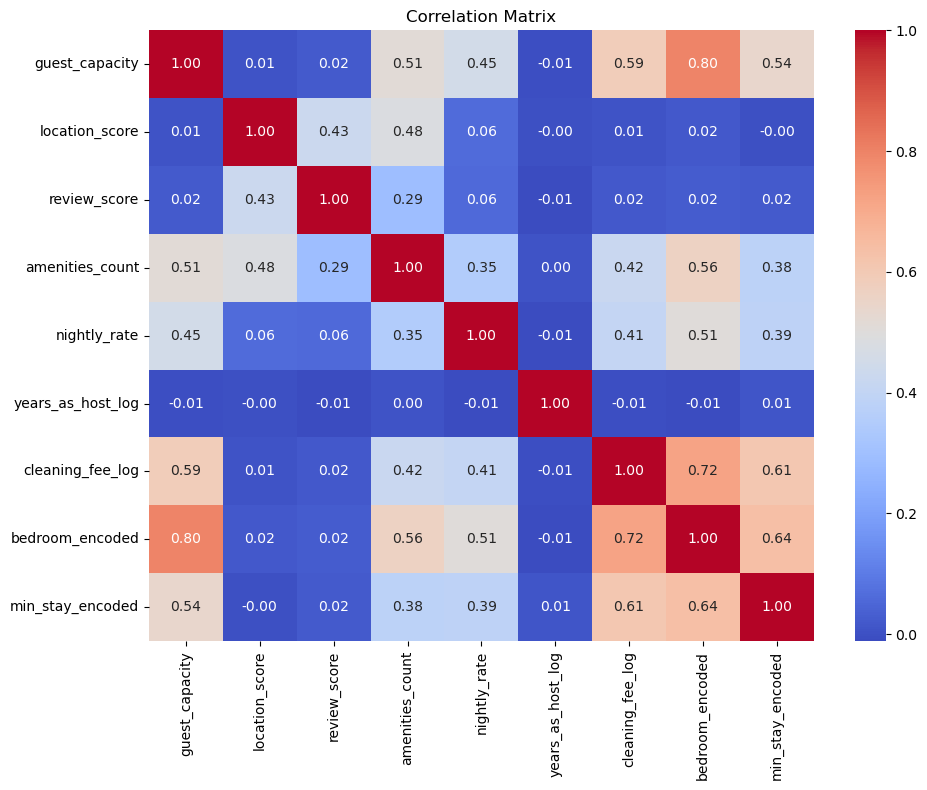

In [18]:
# Correlation Matrix
df_outlier_processed = df_outlier_processed.drop(columns=original_high_skew_cols)
plot_correlations(df_outlier_processed)

#### 1. Correlation between Target(nightly_rate) and variables
     
**High correlation**

- bedroom_encoded(0.51)
- guest_capacity(0.45)
- cleaning_fee_log(0.41)
- min_stay_encoded(0.39)
- amentities_count(0.35)

**Low correlation**

- location_score(0.06)
- review_score (0.06)
- years_at_host_log(-0.01)

-> For LR model : Keep high correlation features, remove low correlation features

#### 2. Correlation between variables

For correlation > 0.6:
- bedroom_encoded <-> guest_capacity
- bedroom_encoded <-> cleaning_fee_log
- bedroom_encoded <-> min_stay_encoded

-> Drop bedroom_encoded variable



In [19]:
df_LR = df_outlier_processed.drop(columns=['bedroom_encoded', 'location_score', 'review_score', 'years_as_host_log', 'cleaning_fee_log'])
num_cols_LR = [col for col in num_cols_processed if col not in ['bedroom_encoded', 'location_score', 'review_score', 'years_as_host_log', 'cleaning_fee_log']]


In [20]:
print(df_LR.columns)
print(num_cols_LR)

Index(['property_type', 'guest_capacity', 'amenities_count',
       'host_response_time', 'season', 'cancellation_policy', 'nightly_rate',
       'min_stay_encoded'],
      dtype='object')
['guest_capacity', 'amenities_count', 'min_stay_encoded']


In [21]:
# VIF Analysis
vif = calculate_vif(df_LR, num_cols_LR)
display(vif)

,feature,VIF
0,guest_capacity,7.477212
1,amenities_count,6.180069
2,min_stay_encoded,3.176495


### Categorical Columns

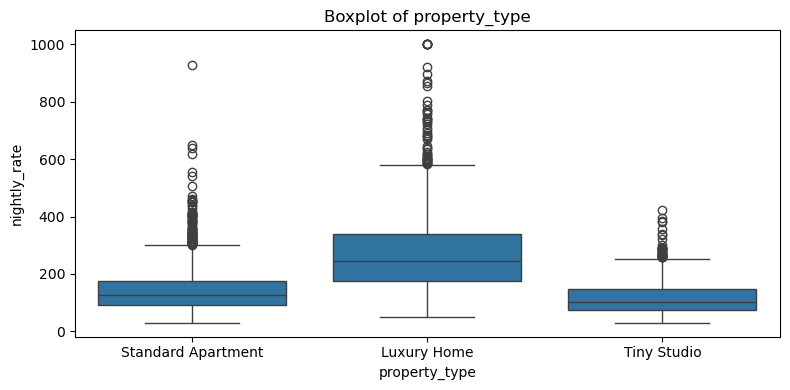

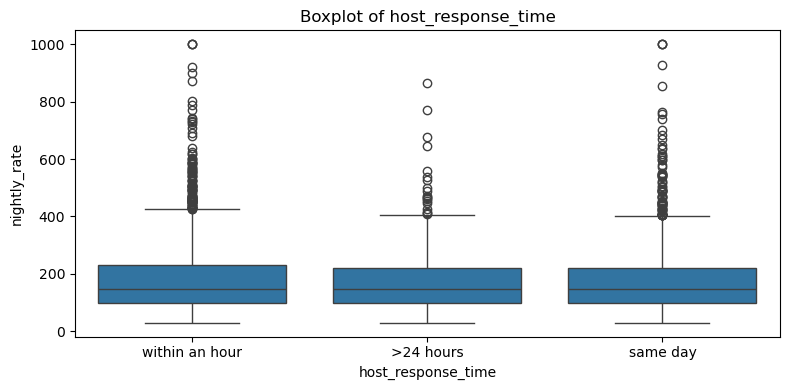

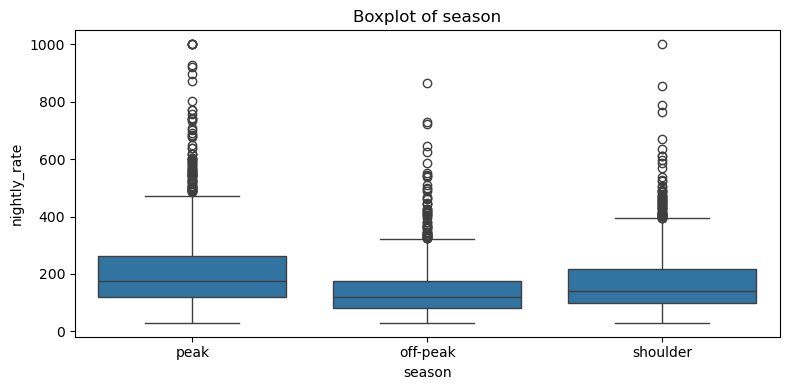

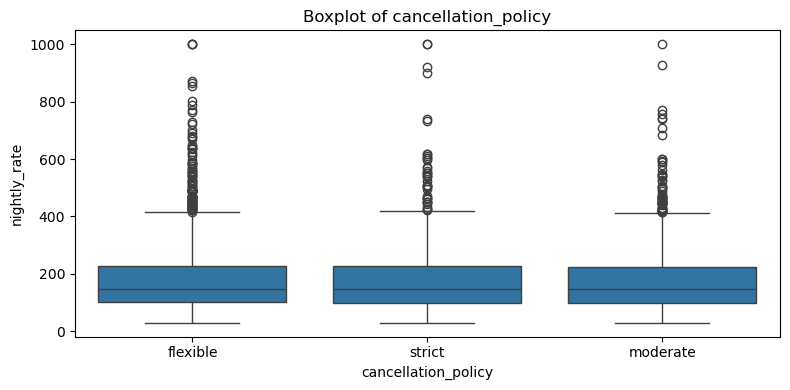

In [22]:
plot_boxplots(df, cat_cols, target)

In [23]:
df_encoded = one_hot_encode(df_outlier_processed, cat_cols)
df_LR = one_hot_encode(df_LR, cat_cols)

In [24]:
df_encoded.head()

,guest_capacity,location_score,review_score,amenities_count,nightly_rate,years_as_host_log,cleaning_fee_log,bedroom_encoded,min_stay_encoded,property_type_Standard Apartment,property_type_Tiny Studio,host_response_time_same day,host_response_time_within an hour,season_peak,season_shoulder,cancellation_policy_moderate,cancellation_policy_strict
0,4,75.17,4.87,8,187.29,0.955511,3.110399,1,1,True,False,False,True,True,False,False,False
1,3,67.07,4.06,6,255.64,1.629241,3.671225,1,1,True,False,False,False,False,False,False,False
2,2,76.57,4.16,10,62.82,1.193922,3.938470,0,0,True,False,True,False,False,False,False,False
3,2,88.14,3.74,11,203.80,0.955511,3.593744,1,1,True,False,True,False,False,True,False,True
4,4,58.63,3.37,15,1000.00,0.641854,4.563306,2,3,False,False,True,False,True,False,False,True


In [25]:
df_LR.head()

,guest_capacity,amenities_count,nightly_rate,min_stay_encoded,property_type_Standard Apartment,property_type_Tiny Studio,host_response_time_same day,host_response_time_within an hour,season_peak,season_shoulder,cancellation_policy_moderate,cancellation_policy_strict
0,4,8,187.29,1,True,False,False,True,True,False,False,False
1,3,6,255.64,1,True,False,False,False,False,False,False,False
2,2,10,62.82,0,True,False,True,False,False,False,False,False
3,2,11,203.80,1,True,False,True,False,False,True,False,True
4,4,15,1000.00,3,False,False,True,False,True,False,False,True


In [27]:
# Save data after EDA Done
df_encoded.to_csv("../data/df_cleaned_encoded.csv", index=False)
df_LR.to_csv("../data/df_LR.csv", index=False)
df_outlier_processed.to_csv("../data/df_cleaned.csv", index=False)